# Week 8 - Multivariate Analysis

## Please run the cells of the notebook as you get to them while reading

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn import decomposition, linear_model, metrics

from sklearn.decomposition import PCA


plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# 1. Lesson: Multivariate graphs

In this lesson, we'll consider some multivariate plots: heatmaps and bubble plots.  We'll also consider principal component analysis and multiple regression.

### Heatmaps

In this plot, we use a heatmap to count the total traffic tickets given to citizens.  A heatmap requires the x and y axes to be categorical, while the color involves a third, numerical variable.  In this example, each row of the DataFrame represents a traffic ticket given to one person in a particular city and year.  The data are given as three columns (city, year, and ticket), so we must use a pivot_table to transform it into a two-dimensional grid.  The cmap is set to "Blues" in the first example, meaning that the heatmap uses only blue as its color.  However, we could also use a multicolor map like "viridis" in the second example.  I personally think "Blues" is easier to read - what do you think?  Here is a reference guide to the color maps:

https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [31]:
np.random.seed(0)
num_samples     = 100
city_series     = np.random.choice(["NYC", "Boston", "Atlanta", "DC"], size = num_samples)
year_series     = np.random.choice([2018, 2019, 2020], size = num_samples)
ticket_series   = np.random.randint(50, 150, size = num_samples) # Traffic tickets can be from $50 to $150

df = pd.DataFrame({"city": city_series, "year": year_series, "ticket": ticket_series})
df 

,city,year,ticket
0,NYC,2019,79
1,DC,2020,71
2,Boston,2018,75
3,NYC,2018,130
4,DC,2020,110
...,...,...,...
95,NYC,2019,111
96,Atlanta,2019,51
97,DC,2018,131
98,Boston,2018,85


In [32]:
pivot = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "sum")


In [33]:
df.iloc[0:5] # first five rows of a long DataFrame

,city,year,ticket
0,NYC,2019,79
1,DC,2020,71
2,Boston,2018,75
3,NYC,2018,130
4,DC,2020,110


In [34]:
pivot # 2 by 2 grid showing total ticket amounts

year,2018,2019,2020
city,,,
Atlanta,742,440,538
Boston,775,628,922
DC,1258,451,1385
NYC,1122,841,596


Text(0.5, 1.0, 'Total traffic tickets by city and year')

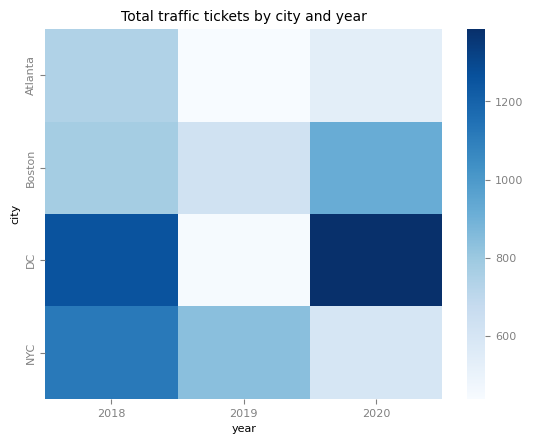

In [35]:
ax = sns.heatmap(pivot, cmap = "Blues")
ax.set_title("Total traffic tickets by city and year")

Text(0.5, 1.0, 'Average traffic ticket value by city and year')

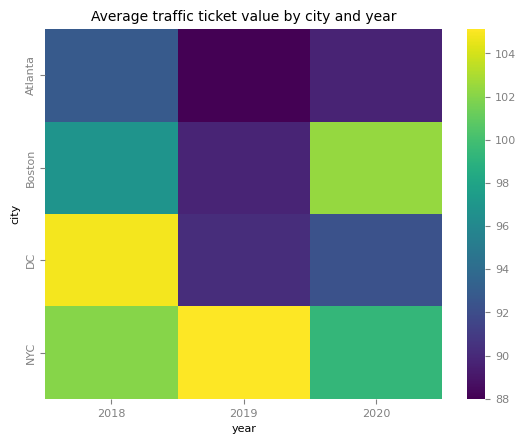

In [36]:
pivot2 = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "mean") # note mean, not sum this time
ax2 = sns.heatmap(pivot2, cmap = "viridis") # do you think this is a better or worse scale than Blues?
ax2.set_title("Average traffic ticket value by city and year")

### Bubble plots

A bubble plot is just a scatter plot, but with the dot size representing a third variable.  Here, each data point shows a tree (I mean the kind of tree that is a plant and grows in the ground, not a decision tree), with its height, width of branches, and root depth.  The bubble size in the bubble plot represents the root depth, while the other variables are shown on the x and y axes.  From this plot, we can see that the root depth is strongly correlated with both the width of branches and the tree height.

Text(0, 0.5, 'width of branches')

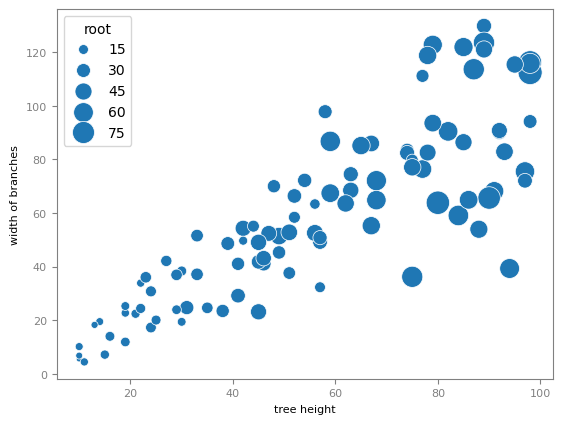

In [37]:
np.random.seed(0)

num_samples     = 100
height_series   = np.random.randint(10, 100, size = num_samples) # tree height
width_series    = height_series * np.maximum(np.random.normal(scale = 0.3, loc = 1, size = num_samples), 0.25) # strongly related to height
root_series     = height_series * np.maximum(np.random.normal(scale = 0.2, loc = 0.7, size = num_samples), 0.3) # strongly related to height

df2         = pd.DataFrame({'height': height_series, 'width': width_series, 'root': root_series})
minroot     = root_series.min()
maxroot     = root_series.max()
maxbubble   = 300

ax          = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

### Principal Component Analysis

Principal Component Analysis can be thought of as a way to use one (or a few) linear combinations of the coordinates in order to explain all of the coordinates.  It is most useful when there are strong correlations between some or all of the coordinates.  Principal Component Analysis can show us which linear combinations are most (and least) useful for explaining the data.

With the trees data, the three values (height, width, and root) are highly correlated.  For this reason, Principal Component Analysis shows that most of the variance can be explained by a single value which is a linear combination of height, width, and root.  What this means is that if the first components_ vector in the code below (the "first principal component") is \[a, b, c\], for some specific numbers a, b, and c, then the value

        `v = [a * (height - mu_h)] + [b * (width - mu_w)] + [c * (root - mu_r)]`, 
 
 
 where the mu's are the means, is highly informative about the values of height, width, and root.  In this case, because height, width, and root are so highly correlated, we can almost assume that all of the data is located along an axis defined by the vector `[a, b, c]`.  
 
 The point `v * [a, b, c] + (mean vector)` =<br> `[a * (height - mu_h)`
                                            `+ b * (width - mu_w)`
                                            `+ c * (root - mu_r)] * [a, b, c] + (mean vector)` 
                                            
is therefore approximately equal to the data point `(height, width, root)` in question.  The mean vector is `[mu_h, mu_w, mu_r]`.  Importantly, there is still variance unexplained by this one value - just knowing `v * \[a, b, c\]` does not tell you the height, width, and root with 100% accuracy.  If the second principal component is `[d, e, f]`, then we could approximate the tree vector even more accurately as: 
 
 `(height, width, root)` = `(a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (mean vector)`.

The printing of "components_", below, shows the first principal component `[a, b, c]`.  If you draw a vector in the direction shown, you will be heading in the direction where the values of height, width, and root change most rapidly.  A later computation shows all three principal component vectors.


**Optional exercise for the reader:** show that if all three principal components are included, then equality is exact.  This is going to be true simply because the principal components are **orthonormal**: the projections onto a complete set of orthonormal vectors always add up to the original vector.

`(height, width, root) = (a * (height - mu_h) + (b * (width - mu_w)) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (g * (height - mu_h) + h * (width - mu_w) + i * (root - mu_r)) * [g, h, i] + [mu_h, mu_w, mu_r]`.

For this proof, we must use the fact that the principal component vectors are orthonormal.  That is, any pair of them are orthogonal, even with a transpose (ad + be + cf = 0, ag + bh + ci = 0, dg + eh + fi = 0, ab + de + gh = 0, ac + df + gi = 0, bc + ef + hi = 0) and any one of them is a unit vector, even with a transpose (a^2 + b^c + c^2 = 1, d^2 + e^2 + f^2 = 1, g^2 + h^2 + i^2 = 1, a^2 + d^2 + g^2 = 1, b^2 + e^2 + h^2 = 1, c^2 + f^2 + i^2 = 1).  

If you write out the equation above as a single vector, then apply the orthonormality rules, you should be able to prove equality.

In [38]:
pca = decomposition.PCA(n_components = 1)

pca.fit(df2)
print(f"The first principal component explains {pca.explained_variance_ratio_[0]} of the variance")
print(f"The components_ vector is [a, b, c] = {pca.components_}")
mu_h, mu_w, mu_r = df2.mean().values

print(f"(height, width, root) is approximately equal to ({pca.components_[0][0]:.2} * (height - {mu_h:.2}) + {pca.components_[0][1]:.2} * (width - {mu_w:.2}) + {pca.components_[0][2]:.2} * (root - {mu_r:.2})) * ({pca.components_[0][0]:.2}, {pca.components_[0][1]:.2}, {pca.components_[0][2]:.2}) + ({mu_h:.2}, {mu_w:.2}, {mu_r:.2})")
print("Examples: (estimating the the vector equals its projection onto the first principal component)")

df_example = df2.copy()
df_example["v"] = pca.components_[0][0] * (df2["height"] - mu_h) + pca.components_[0][1] * (df2["width"] - mu_w) + pca.components_[0][2] * (df2["root"] - mu_r)

df_example["height_est"]    = df_example["v"] * pca.components_[0][0] + mu_h
df_example["width_est"]     = df_example["v"] * pca.components_[0][1] + mu_w
df_example["root_est"]      = df_example["v"] * pca.components_[0][2] + mu_r

print(df_example.iloc[0:5])
print("Means:")
print(f"mu_h = {mu_h:.3}", f"mu_w = {mu_w:.3}", f"mu_r = {mu_r:.3}")

The first principal component explains 0.8686108480944679 of the variance
The components_ vector is [a, b, c] = [[0.59031629 0.71908728 0.36666083]]
(height, width, root) is approximately equal to (0.59 * (height - 5.6e+01) + 0.72 * (width - 5.9e+01) + 0.37 * (root - 3.6e+01)) * (0.59, 0.72, 0.37) + (5.6e+01, 5.9e+01, 3.6e+01)
Examples: (estimating the the vector equals its projection onto the first principal component)
   height       width       root          v  height_est  width_est   root_est
0      54   72.139334  31.517932   6.287751   60.001762  63.563941  38.673095
1      57   49.169527  33.768693  -7.633330   51.783921  53.553468  33.568780
2      74   83.443733  28.770850  25.215680   71.175227  77.174773  45.613225
3      77   76.353866  53.061241  30.794730   74.468631  81.186597  47.658844
4      77  111.095365  26.006307  45.856916   83.360084  92.017624  53.181557
Means:
mu_h = 56.3 mu_w = 59.0 mu_r = 36.4


If we were to choose a second or third component to preserve, that values below show that each would explain a small, additional amount of the variance.  This means that with this particular dataset, we should likely do PCA using only one component and not two.  If the components' explained variances were closer in magnitude to each other, we might have to include two or even all three values to explain the data.

In [39]:
pca3 = decomposition.PCA(n_components = 3)
pca3.fit(df2)

print(pca3.explained_variance_ratio_)
print(pca3.components_)

[0.86861085 0.09414617 0.03724298]
[[ 0.59031629  0.71908728  0.36666083]
 [ 0.32633701 -0.62809127  0.70640322]
 [ 0.73826204 -0.29734633 -0.6054373 ]]


The principal component vectors shown are orthogonal to each other (their dot product is basically zero).  Here, we check that using the first two vectors.

In [40]:
print(np.array(pca3.components_[0]).dot(np.array(pca3.components_[1])))

1.3495329050818075e-16


We can use the projection onto the first principal component as if it were a new feature.  For instance, we could plot a histogram of the data against the magnitude of the projection onto the first principal component.  In fact, for some purposes, this magnitude (which we have called v) might make a better feature for data analysis than either height, width, or root.  We must subtract off the mean before the dot product; the understanding is that this represents the component of the data relative to the mean.

<Axes: >

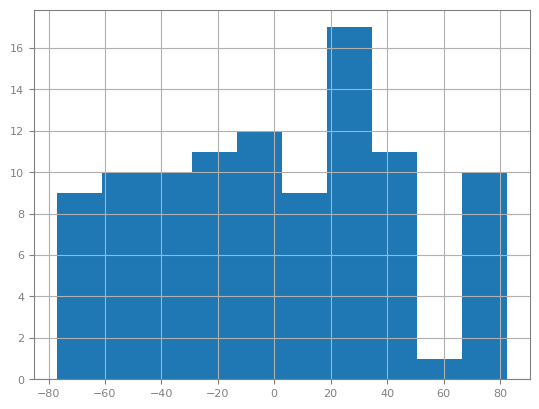

In [41]:
((df2 - df2.mean()).dot(np.array(pca.components_[0]))).hist()

In [42]:
# Showing that this is the same as the value we've called "v"
(df_example["v"] - (df2 - df2.mean()).dot(np.array(pca.components_[0]))).max()

2.842170943040401e-14

### Linear Regression

Now let's run a linear regression model to predict the root from the height and width, as well as predicting the third principal component from the first and second.  Which is easier to predict?

### Predicting the root from the height and width

In [43]:
linreg = linear_model.LinearRegression()
linreg.fit(df2[['height', 'width']], df2['root'])

preds = linreg.predict(df2[['height', 'width']])
metrics.mean_squared_error(preds, df2['root']) # Mean squared error as a metric

138.22487356329611

In [44]:
np.corrcoef(preds, df2['root']) # Correlation coefficient as a metric

array([[1.        , 0.79468295],
       [0.79468295, 1.        ]])

### Predicting the third principal component from the first and second

In [45]:
first_principal_component_score     = (df2 - df2.mean()).dot(np.array(pca3.components_[0]))
second_principal_component_score    = (df2 - df2.mean()).dot(np.array(pca3.components_[1]))
third_principal_component_score     = (df2 - df2.mean()).dot(np.array(pca3.components_[2]))

In [46]:
linreg_first    = linear_model.LinearRegression()
pc_X            = np.array([first_principal_component_score, second_principal_component_score]).T

linreg_first.fit(pc_X, third_principal_component_score)
preds = linreg_first.predict(pc_X)
metrics.mean_squared_error(preds, third_principal_component_score) # The mean squared error is a bit smaller here.

78.74928905273173

In [47]:
np.corrcoef(preds, third_principal_component_score) # More importantly, the correlation is basically zero

array([[1.00000000e+00, 2.33264019e-16],
       [2.33264019e-16, 1.00000000e+00]])

Here, we see that the projections of the first two principal components have no ability to predict the projection of the third, when measured by correlation.  This is a special property of principal components.  It is intended to ensure that the each component gives new information not present in the previous components.

The mean_squared_error is misleading - it makes it look like the error is less for the second computation than the first; but the correlation coefficient is giving more useful information here.  We cannot compare the mean squared error for two totally different computations, because mean squared error is highly dependent on the magnitudes of the values in question!

# 2. Weekly graph question

The tree data above can be graphed via either a pairplot or a bubble plot.  What are the advantages and disadvantages of each?

Text(0, 0.5, 'width of branches')

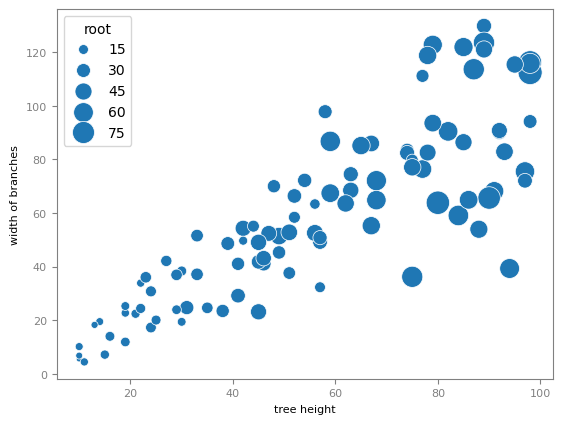

In [48]:
ax = sns.scatterplot(data   = df2, 
                     x      = "height", 
                     y      = "width", 
                     size   = "root", 
                     sizes  = (minroot / maxroot * maxbubble, maxbubble)
                     )
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

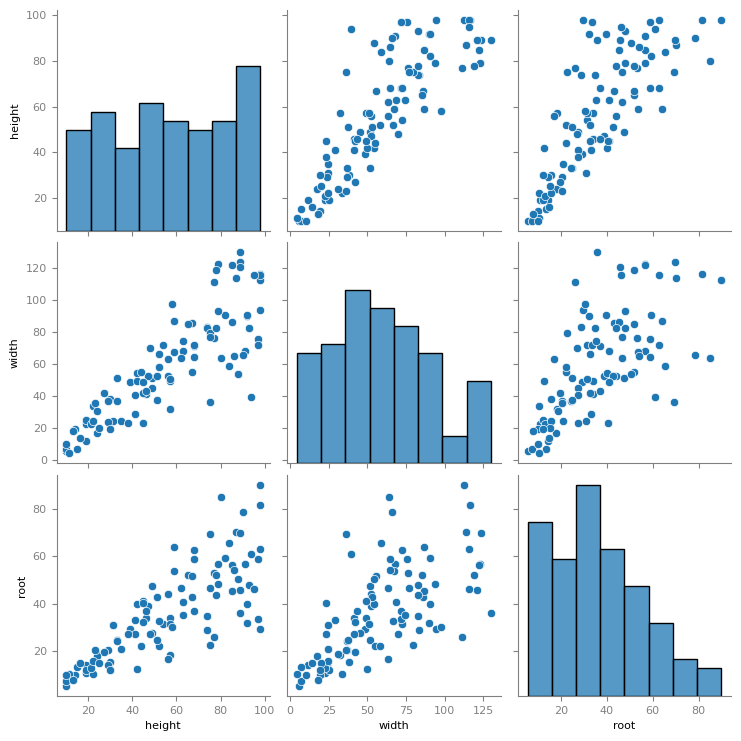

In [49]:
sns.pairplot(df2)

# 3. Homework - Grocery Store Correlation

In a particular state, the price of milk is highly correlated with the price of cheese.  Neither is correlated with the price of bread.

In [50]:
num_points      = 1000
np.random.seed(0)

milk_series     = np.maximum(np.random.normal(scale = 0.5, loc = 2.00, size = num_points), 1)
cheese_series   = milk_series * np.maximum(np.random.normal(scale = 0.1, loc = 1.00, size = num_points), 0.5)
bread_series    = np.maximum(np.random.normal(scale = 1.0, loc = 3.00, size = num_points), 1)

df3             = pd.DataFrame(
        {"milk": milk_series, 
        "cheese": cheese_series,
        "bread": bread_series
        }
        )
df3

,milk,cheese,bread
0,2.882026,3.042256,1.467079
1,2.200079,2.396430,1.288030
2,2.489369,2.384239,3.046135
3,3.120447,3.153122,2.041626
4,2.933779,3.000685,2.919188
...,...,...,...
995,2.206435,2.228003,5.079177
996,1.900801,2.167202,2.092534
997,2.047096,2.079529,2.807596
998,1.426195,1.263337,1.787484


### Heatmap

Draw a heatmap where the x-axis category is a discretized version of the milk price and the y-axis category is a discretized version of the cheese price.  That is, you can choose "low", "medium", and "high" for the milk price, or, if you prefer, you can choose 1, 2, 3, 4, and 5 for the five quintiles.  (The first quintile should include the bottom fifth of the data, the second quintile contains the next fifth, and so on).

Try Googling "how do I change numerical to categorical data" to get advice on this.

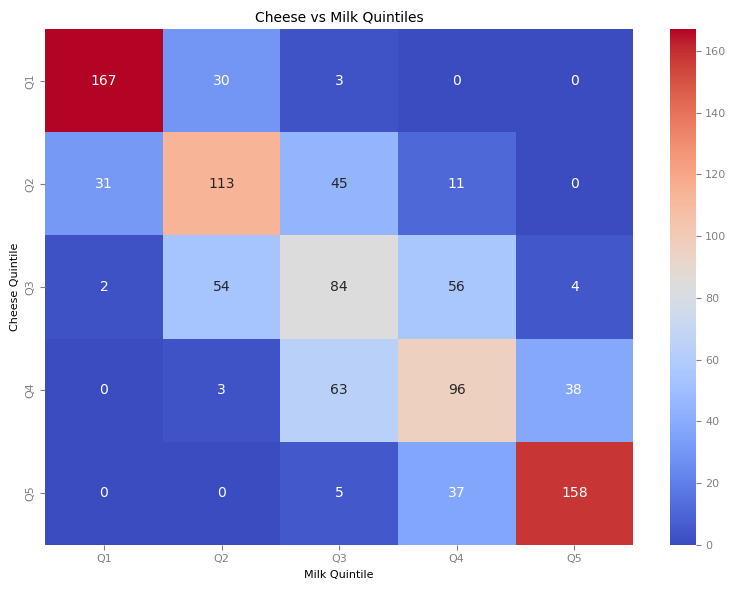

In [51]:
df3h = df3.copy()
# Discretize milk and cheese into quintiles
df3h['milk_quintile']    = pd.qcut(df3h['milk'], 5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])
df3h['cheese_quintile']  = pd.qcut(df3h['cheese'], 5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])

# heatmap of counts
heatmap_data = pd.crosstab(df3h['cheese_quintile'], df3h['milk_quintile'])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')
plt.title("Cheese vs Milk Quintiles")
plt.xlabel("Milk Quintile")
plt.ylabel("Cheese Quintile")
plt.tight_layout()
plt.show()


### Bubble plot

Try all three possible bubble plots: one where the size of the dot is determined by the milk price, one where it's the cheese price, and one where it's the bread price.  Which of these plots is / are the most informative and useful?

In [52]:

def plot_bubble_size(df, x_col:str, y_col:str, size_col:str, xlabel:str, ylabel:str, size_color:str = 'midnightblue'):
    """
    Function to create a bubble plot with specified x and y columns,
    size based on a specified column.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col], s = df[size_col]*20, alpha = 0.5, color = size_color)
    plt.title(f'{x_col} vs {y_col}, Size by {size_col}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


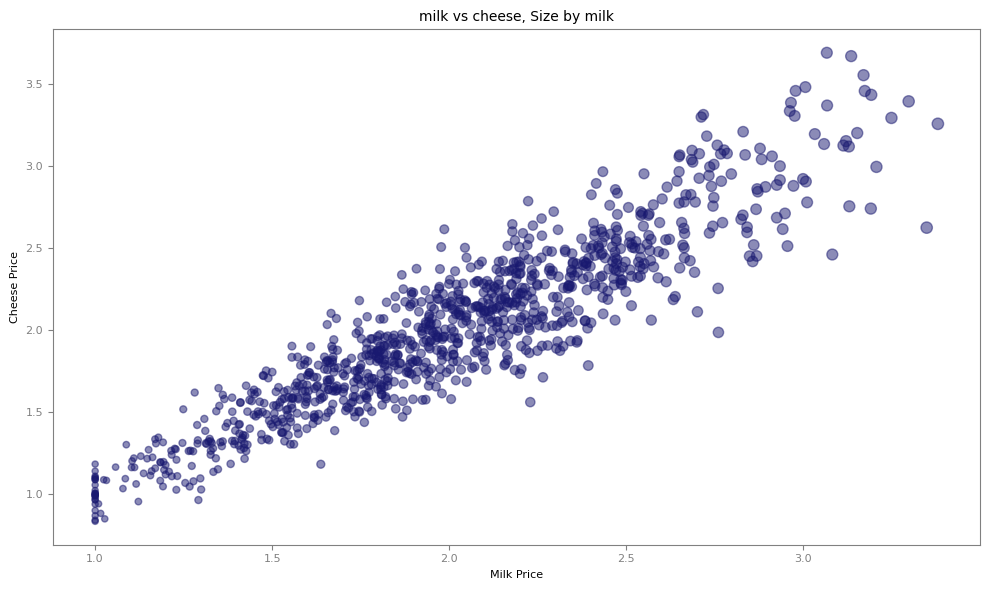

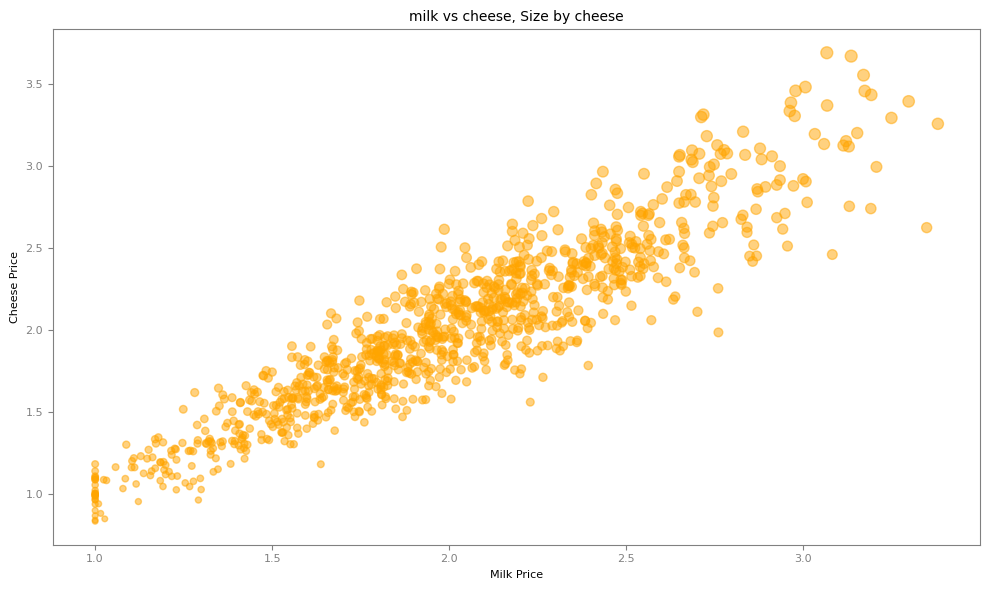

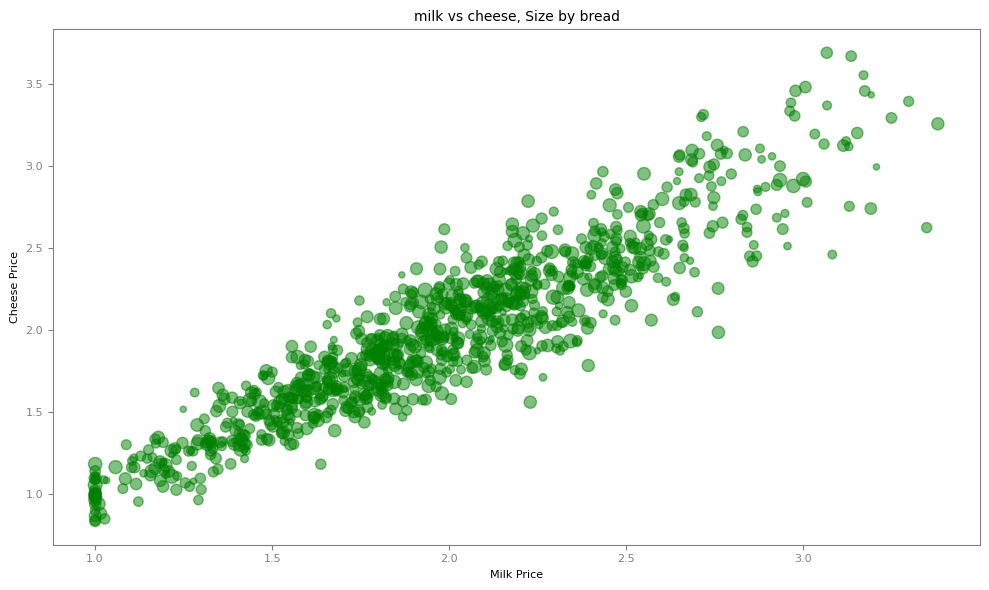

In [53]:
plot_bubble_size(df3, x_col='milk', y_col='cheese', size_col ='milk',xlabel = "Milk Price", ylabel = "Cheese Price")
plot_bubble_size(df3, x_col='milk', y_col='cheese', size_col ='cheese',xlabel = "Milk Price", ylabel = "Cheese Price", size_color = 'orange')
plot_bubble_size(df3, x_col='milk', y_col='cheese', size_col ='bread',xlabel = "Milk Price", ylabel = "Cheese Price", size_color = 'green')

### Principal component analysis

Perform a principal component analysis of the data.  What are the first, second, and third component vectors?

Challenge question: explain why the three vectors point as they do.  (Could someone have guessed the order of the three vectors, even before running the analysis?)

In [54]:

pca = PCA(n_components=3)
pca.fit(df3)

# Extract the principal component vectors
components = pca.components_

component_vectors = pd.DataFrame(components, columns=df3.columns, index=["PC1", "PC2", "PC3"])
component_vectors

,milk,cheese,bread
PC1,-0.038256,-0.038095,0.998542
PC2,0.678738,0.732396,0.053945
PC3,0.733383,-0.679812,0.002162


<font color='plum'>

1. **PC1**:
   - Dominated by **bread** variable (coefficient ≈ 0.999).
   - largest variance in dataset is due to variation in bread price, which is independent of milk and cheese.

2. **PC2**:
   - Captures SHARED VARIANCE between milk and cheese, which makes sense because cheese is generated as a function of milk.
   - Strong positive contributions from both **milk** and **cheese**.

3. **PC3**:
   - captures RESIDUAL differences between milk and cheese after accounting for their shared variance.
   - A contrast between **milk** and **cheese** (positive vs. negative weights), with almost no contribution from bread.

### Could Someone Have Guessed the Order?
Yes, to some extent:

- **Bread** was generated independently of milk and cheese, with a larger variance (standard deviation = 1.0 vs. 0.5 for milk), so it makes sense that it dominates the first principal component.

- **Cheese** is a function of **milk**, so we can expect high correlation. This shared structure naturally forms the second principal component.
- Third component then captures the *orthogonal contrast* between milk and cheese, which is subtle and residual.



### Linear regression

Use linear regression to predict the milk price from the other two, the cheese price from the other two, and the bread price from the other two.  Which prediction(s) work the best, and why?

In [55]:

def linear_regression_predictor(df, target_col, feature_cols, pred_color='midnightblue'):
    """
    linear regression, returns the model object and predictions and plots Predicted vs Actual values.
    
        Parameters:
            df (DataFrame): The input DataFrame containing the data.
            target_col (str): The column name of the target variable.
            feature_cols (list): A list of column names to be used as features.
        
        Returns:
            model: The trained linear regression model.
            predictions: The predictions made by the model.
    """
    linreg = linear_model.LinearRegression()
    linreg.fit(df[feature_cols], df[target_col])
    
    predictions = linreg.predict(df[feature_cols])
    
        # Plotting the predictions against the actual values
    plt.figure(figsize=(7, 4))
    plt.scatter(df[target_col], predictions, alpha=0.5, c=pred_color, label='Predictions', s=5)
    
    plt.plot([df[target_col].min(), df[target_col].max()], [df[target_col].min(), df[target_col].max()], color='black', linestyle='--', linewidth=0.5)  # Diagonal line for reference
    plt.scatter(df[target_col], df[target_col], color='red', alpha = 0.5, label='Actual', s=3)
    
    plt.xlabel(f'Actual {target_col} Price')
    plt.ylabel(f'Predicted {target_col} Price')
    plt.title(f'{target_col} Prices: Linear Regression Predictions vs Actual Values\nR²: {linreg.score(df[feature_cols], df[target_col]):.3f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return linreg, predictions

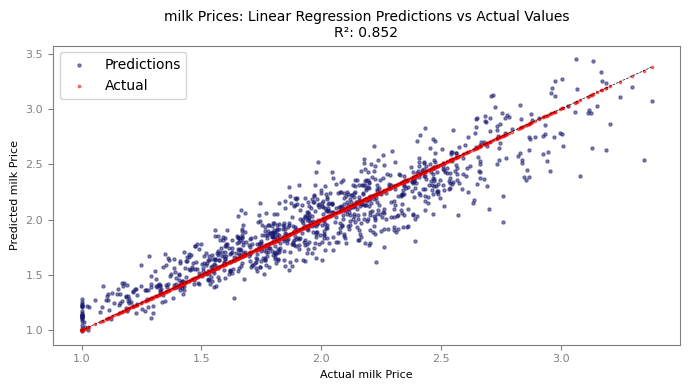

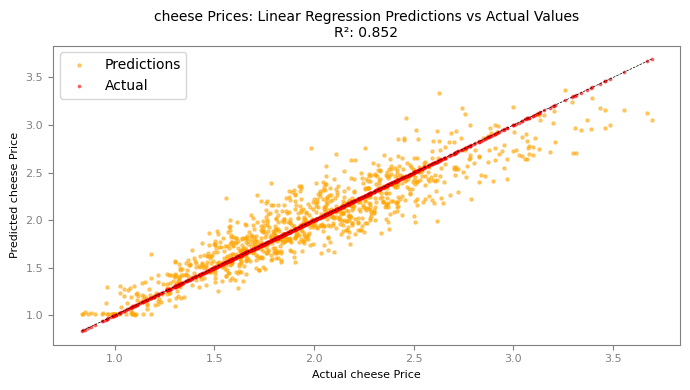

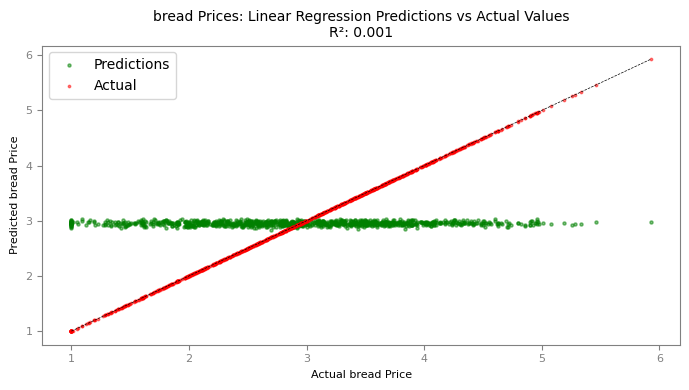

In [56]:
linreg_model_1, milk_predictions      = linear_regression_predictor(df3, target_col='milk', feature_cols=['cheese', 'bread'])
linreg_model_2, cheese_predictions    = linear_regression_predictor(df3, target_col='cheese', feature_cols=['milk', 'bread'], pred_color='orange')
linreg_model_3, bread_predictions     = linear_regression_predictor(df3, target_col='bread', feature_cols=['milk', 'cheese'], pred_color='green')

In [57]:
df3['predicted_milk'] = milk_predictions
df3['predicted_cheese'] = cheese_predictions
df3['predicted_bread'] = bread_predictions
df3

,milk,cheese,bread,predicted_milk,predicted_cheese,predicted_bread
0,2.882026,3.042256,1.467079,2.899280,2.872055,2.899894
1,2.200079,2.396430,1.288030,2.344188,2.196676,2.947529
2,2.489369,2.384239,3.046135,2.326703,2.485699,2.917842
3,3.120447,3.153122,2.041626,2.992407,3.108946,2.879432
4,2.933779,3.000685,2.919188,2.857728,2.925464,2.893278
...,...,...,...,...,...,...
995,2.206435,2.228003,5.079177,2.184158,2.208646,2.941306
996,1.900801,2.167202,2.092534,2.143712,1.901603,2.970229
997,2.047096,2.079529,2.807596,2.065416,2.047503,2.952516
998,1.426195,1.263337,1.787484,1.367050,1.431298,2.988328


# 4. Storytelling With Data plot



Reproduce any graph of your choice in p. 120-135 of the Storytelling With Data book as best you can.  ("Use color consistently" in chapter four up to "Create a clear visual hierarchy of information" in chapter five.)    You do not have to get the exact data values right, just the overall look and feel.

<font color='plum'> Figure 5.4 on page 133 of *Storytelling with Data* 

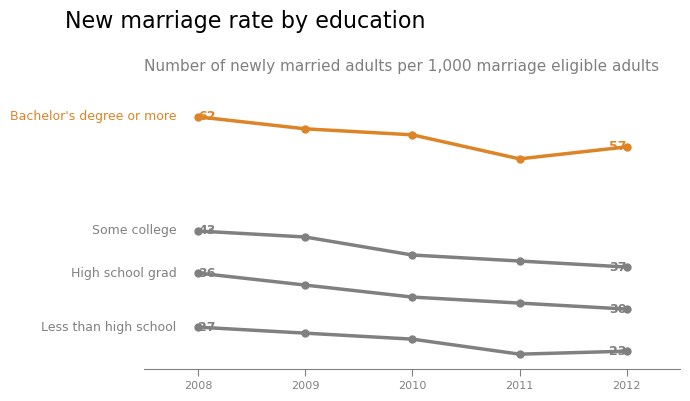

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Data derived from the visual information in the plot
years           = [2008, 2009, 2010, 2011, 2012]
bachelors       = [62, 60, 59, 55, 57]
some_college    = [43, 42, 39, 38, 37]
high_school     = [36, 34, 32, 31, 30]
less_than_high_school = [27, 26, 25, 22.5, 23]

dict = {
    "Bachelor's degree or more": bachelors,
    "Some college": some_college,
    "High school grad": high_school,
    "Less than high school": less_than_high_school
}

fig, ax = plt.subplots(figsize=(7, 4))

# Plot each data series
#only plot markers at beginning and end of each line

ax.plot(years, bachelors, color='#DD8426', linewidth=2.5, marker='o', markersize=5, markerfacecolor='#DD8426', markeredgecolor='#DD8426')
for series in list(dict.values())[1:]:
    ax.plot(years, series, color='gray', linewidth=2.5, marker='o', markersize=5, markerfacecolor='gray', markeredgecolor='gray')


# Set the title and subtitle, adjusting position and appearance
fig.suptitle('New marriage rate by education', fontsize=16, ha='left', x=0.1, y=0.99)
ax.set_title('Number of newly married adults per 1,000 marriage eligible adults', loc='left', fontsize=11, color='gray', pad=20)

# Add category labels to the left of the lines
ax.text(2007.8, 62, "Bachelor's degree or more", ha='right', va='center', fontsize=9, color='#DD8426')

for i, (label, series) in enumerate(dict.items()):
    if i > 0:  # Skip the first label since it's already added
        ax.text(2007.8, series[0], label, ha='right', va='center', fontsize=9, color='gray')


# Add data value labels at the start and end of each line
ax.text(years[0], bachelors[0], bachelors[0], ha='left', va='center', color='#DD8426', fontsize=9, fontweight='bold')
ax.text(years[-1], bachelors[-1], bachelors[-1], ha='right', va='center', color='#DD8426', fontsize=9, fontweight='bold')
for series in [some_college, high_school, less_than_high_school]:
    ax.text(years[0], series[0], str(series[0]), ha='left', va='center', color='gray', fontsize=9, fontweight='bold')
    ax.text(years[-1], series[-1], str(series[-1]), ha='right', va='center', color='gray', fontsize=9, fontweight='bold')


# Customize the axes and remove spines and grid
ax.set_xlim(2007.5, 2012.5)
ax.set_ylim(20, 65)
ax.set_xticks(years)
ax.set_xticklabels(years, fontsize=8)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.tick_params(axis='x', which='both', bottom=True, top=False, length=5)
ax.tick_params(axis='y', which='both', left=False, right=False)
ax.grid(False)

# Display the plot
plt.tight_layout()
plt.show()